In [62]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import sys

まずはサンプルデータの準備から．サンプリング周波数や，サンプルデータの長さを定義．

In [63]:
# Setting
sampling_freq = 50  # [Hz]
sampling_interval = 1.0 / sampling_freq  # [sec]
data_num = 2500
base_frequencies = [0.2, 0.4, 0.8, 1.6, 3.2]

ウェーブレットの名前と，後々プロットに使用するカラーマップを定義．

In [64]:
wavelet_name = 'gaus1'
cmap = 'cividis'

インプットデータを準備．

In [65]:
# Preparing input data
time_array = np.linspace(0.0, sampling_interval * data_num, data_num)
input_data = np.sin(2.0 * np.pi * time_array)
num_input_freqs = len(base_frequencies)
for i, freqs in enumerate(base_frequencies):
    input_data[int(i * data_num / num_input_freqs):int((i + 1) * data_num / num_input_freqs)] = \
        np.sin(2.0 * freqs * np.pi *
               time_array[int(i * data_num / num_input_freqs):int((i + 1) * data_num / num_input_freqs)])

入力するインプットデータと，ウェーブレット変換した後の結果を表示する関数を用意．

In [66]:
def plot_input_data(axis, x, y):
    axis.set_title('input data')
    axis.plot(x, y)
    axis.set_xlabel('Time [sec]')
    axis.set_ylabel('Signal')
    axis.set_xlim(np.min(x), np.max(x))


def plot_wavelet_data(axis, time, freq, coef, title, xscale, color=cmap):
    xx, yy = np.meshgrid(time, freq)

    axis.set_title(title)
    axis.pcolormesh(xx, yy, coef, shading='nearest', cmap=color)
    axis.set_xlabel('Time [sec]')
    axis.set_ylabel('Frequencies [Hz]')
    axis.set_yscale(xscale)

    
def plot_results(time, input_sig, freq, coef, title='Wavelet results', xscale='linear'):
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plot_input_data(ax1, time, input_sig)
    plot_wavelet_data(ax2, time, freq, coef, title, xscale)
    plt.tight_layout()
    plt.show()
    plt.close()

まずはシンプルなウェーブレット変換から．

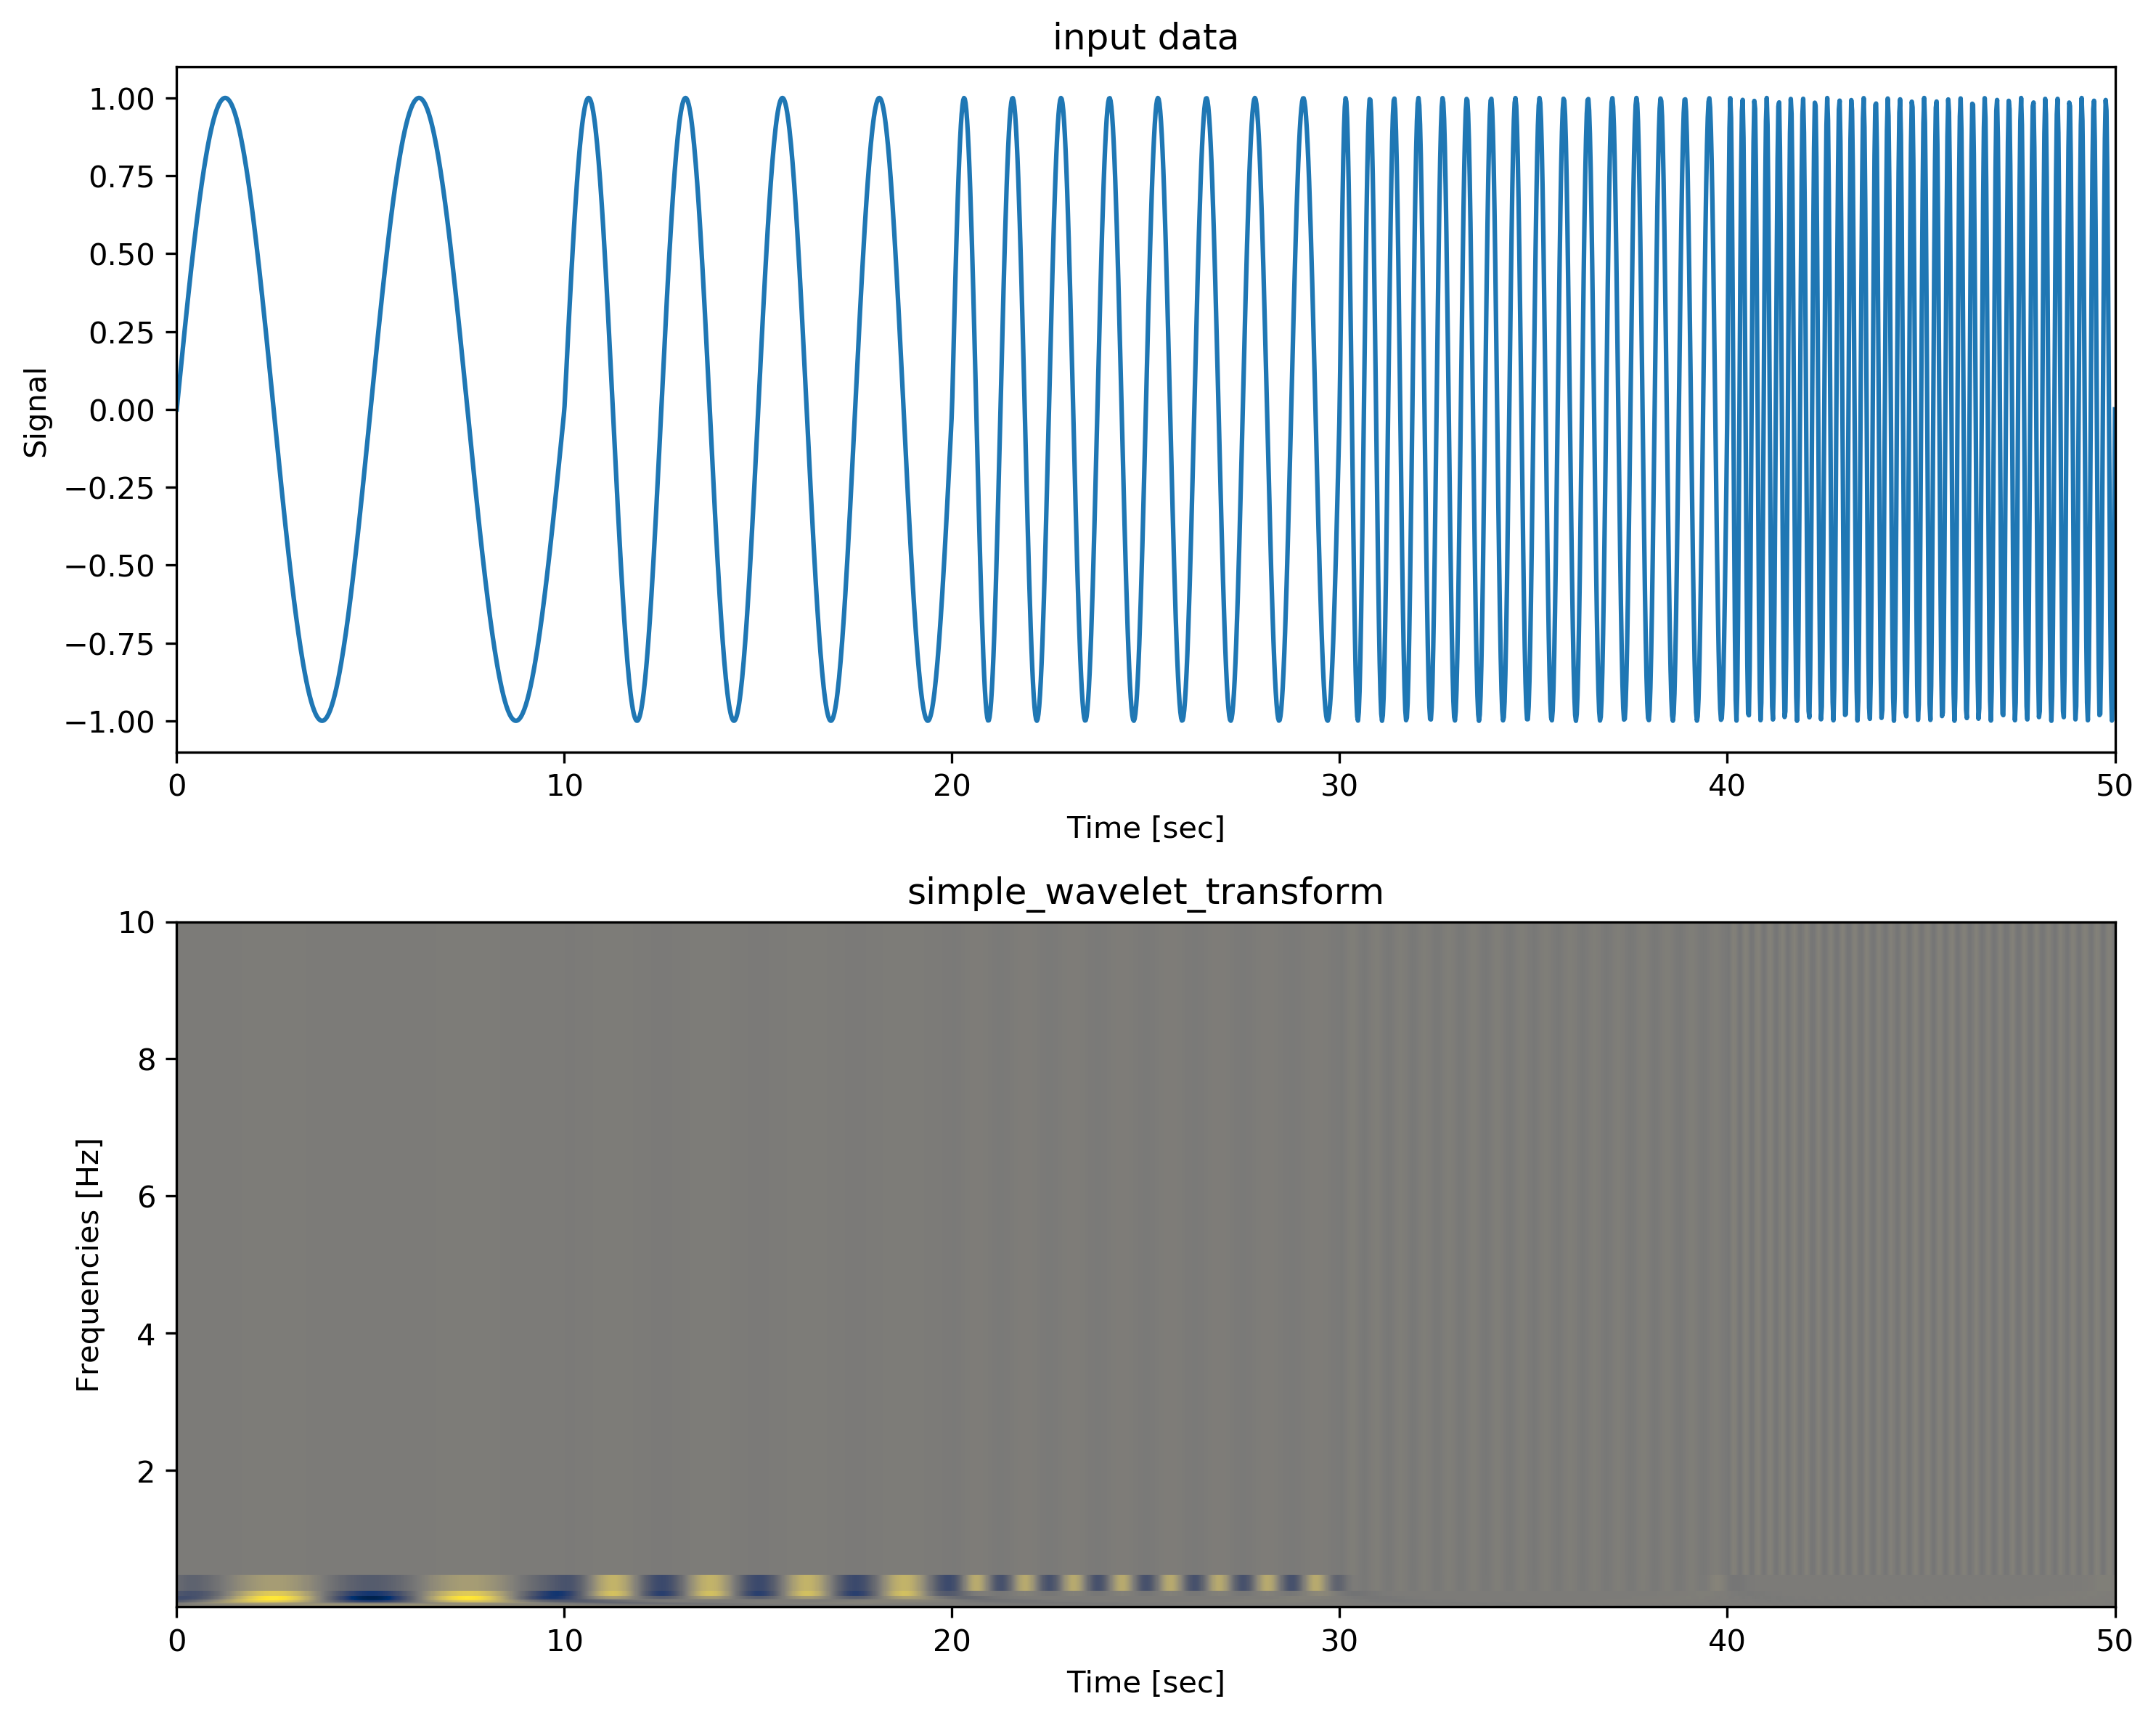

In [67]:
def simple_wavelet_transform(input_sig, wavelet=wavelet_name):
    scale_list_linear = np.linspace(1.0, 1000, 50)
    coef, freq = pywt.cwt(input_sig, scale_list_linear, wavelet=wavelet, sampling_period=sampling_interval)
    plot_results(time_array, input_sig, freq, coef, title=sys._getframe().f_code.co_name)


simple_wavelet_transform(input_data)

なんか出ましたね笑．よく考えると，変換時のパラメータとして指定したスケールのと出力される周波数は逆数の関係にあるので，ウェーブレット変換結果の縦方向は等間隔ではないように見えます．そこで，縦軸を対数軸にしてみます．

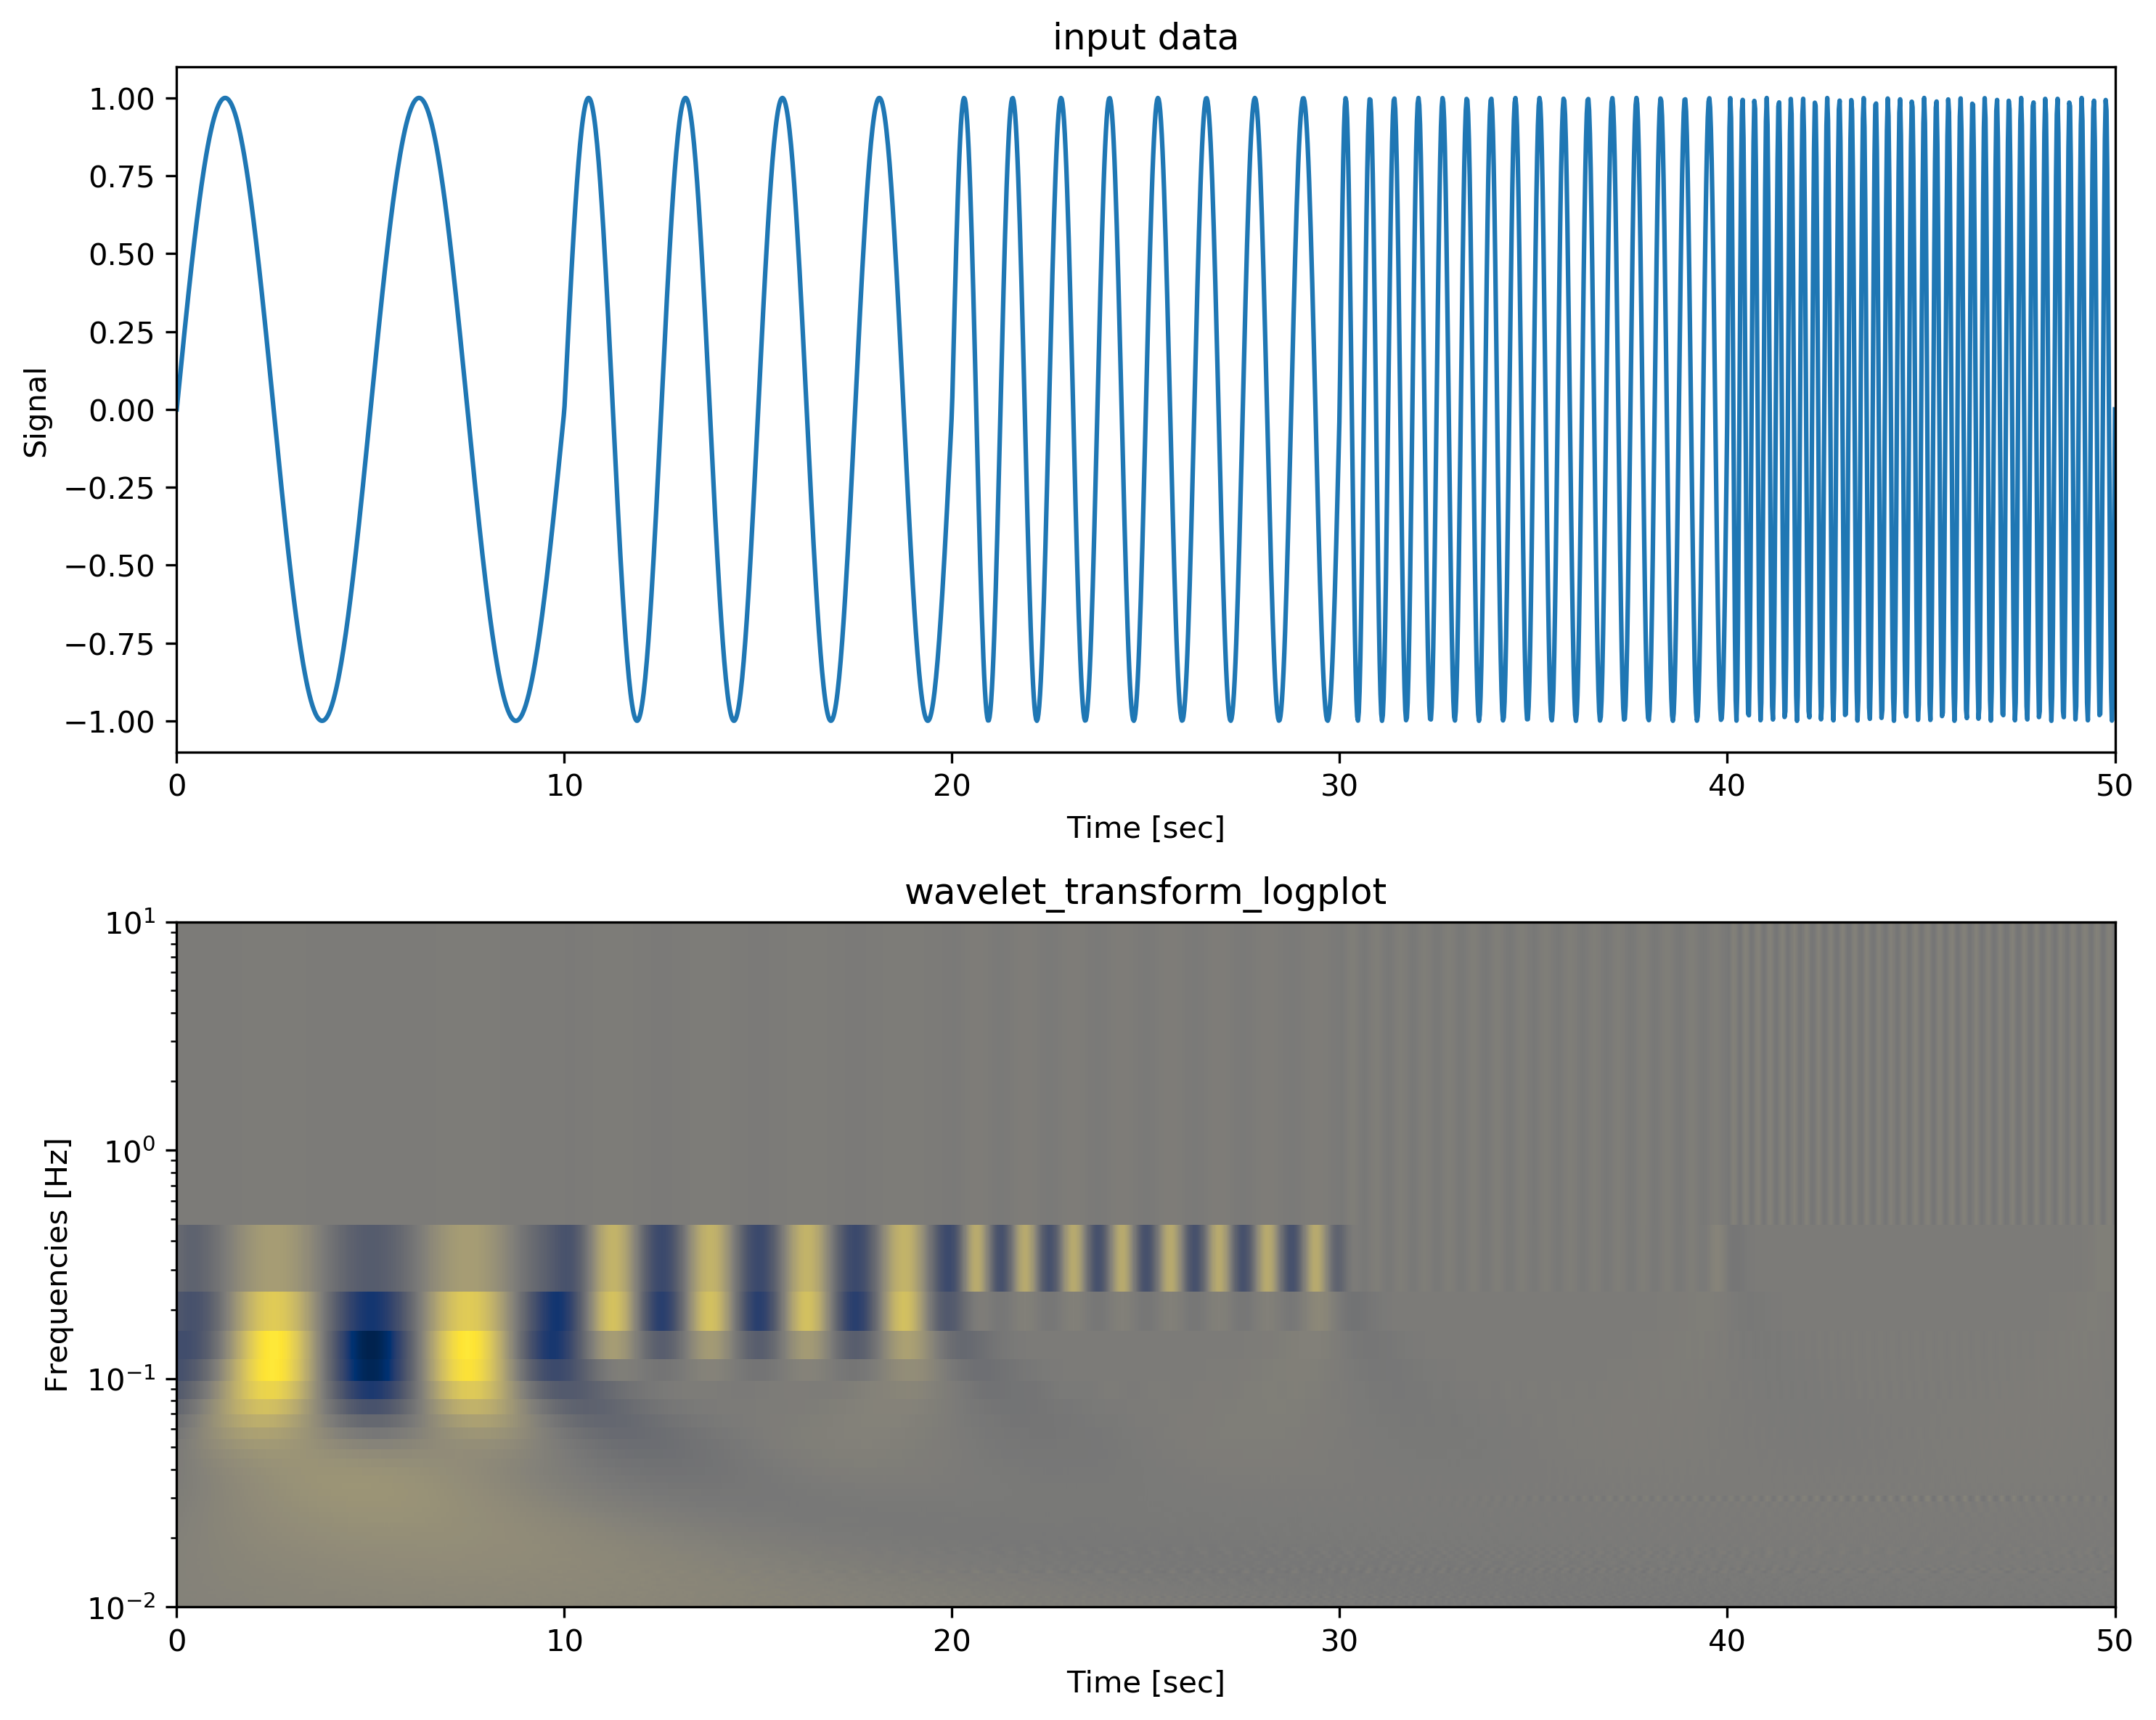

In [68]:
def wavelet_transform_logplot(input_sig, wavelet=wavelet_name):
    scale_list_linear = np.linspace(1.0, 1000, 50)
    coef, freq = pywt.cwt(input_sig, scale_list_linear, wavelet=wavelet, sampling_period=sampling_interval)
    plot_results(time_array, input_sig, freq, coef, title=sys._getframe().f_code.co_name, xscale='log')


wavelet_transform_logplot(input_data)

いくらか見えてきましたね．ただし，もともとスケールのリスト自体が線形な配列を渡しているので，ログスケールでも一部バラバラです．そこで，ウェーブレットに渡すスケールの配列を等比数列にしてみます．

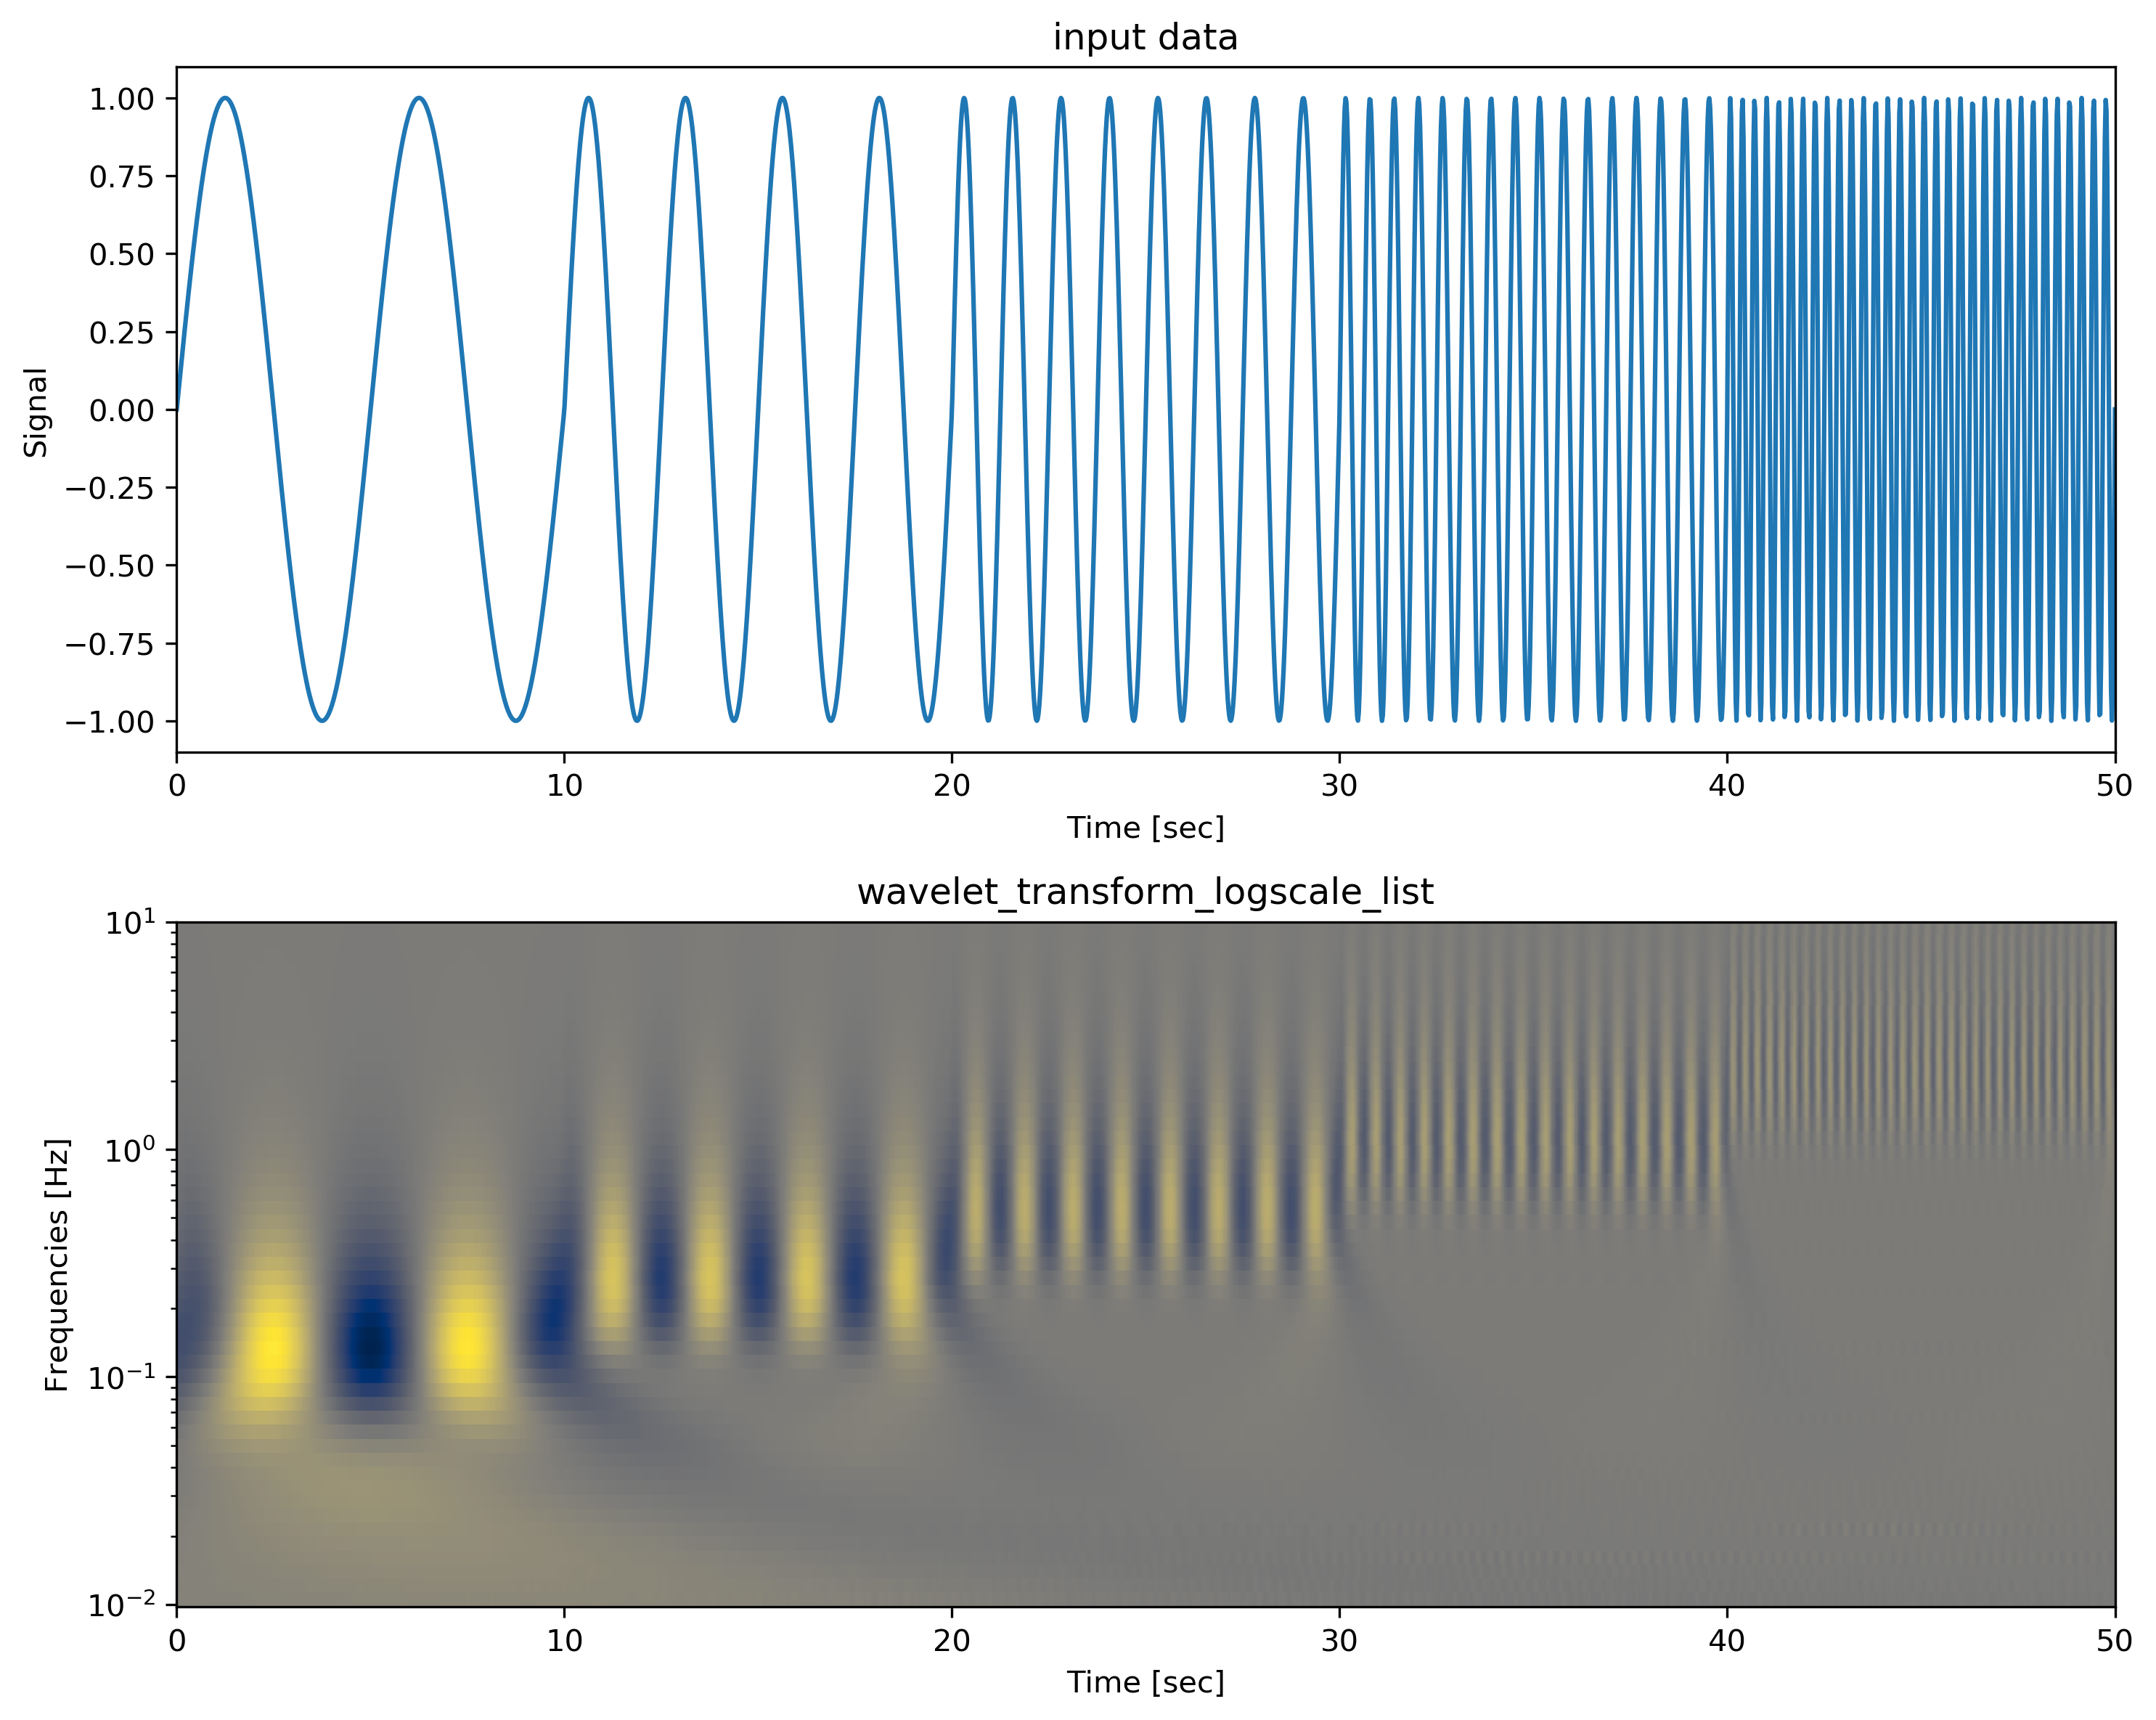

In [69]:
def wavelet_transform_logscale_list(input_sig, wavelet=wavelet_name):
    scale_list = np.power(2.0, np.linspace(0.0, 10, 50))
    coef, freq = pywt.cwt(input_sig, scale_list, wavelet=wavelet, sampling_period=sampling_interval)
    plot_results(time_array, input_sig, freq, coef, title=sys._getframe().f_code.co_name, xscale='log')


wavelet_transform_logscale_list(input_data)

だいぶ滑らかになりましたね．信号の正負が反映されて明暗部が分かれているようですが，正負の符号よりも，どの周波数が支配的かだけが気になる時も多いと思います．そこで試しにウェーブレット変換で帰ってくる信号の絶対値を取ってみます．

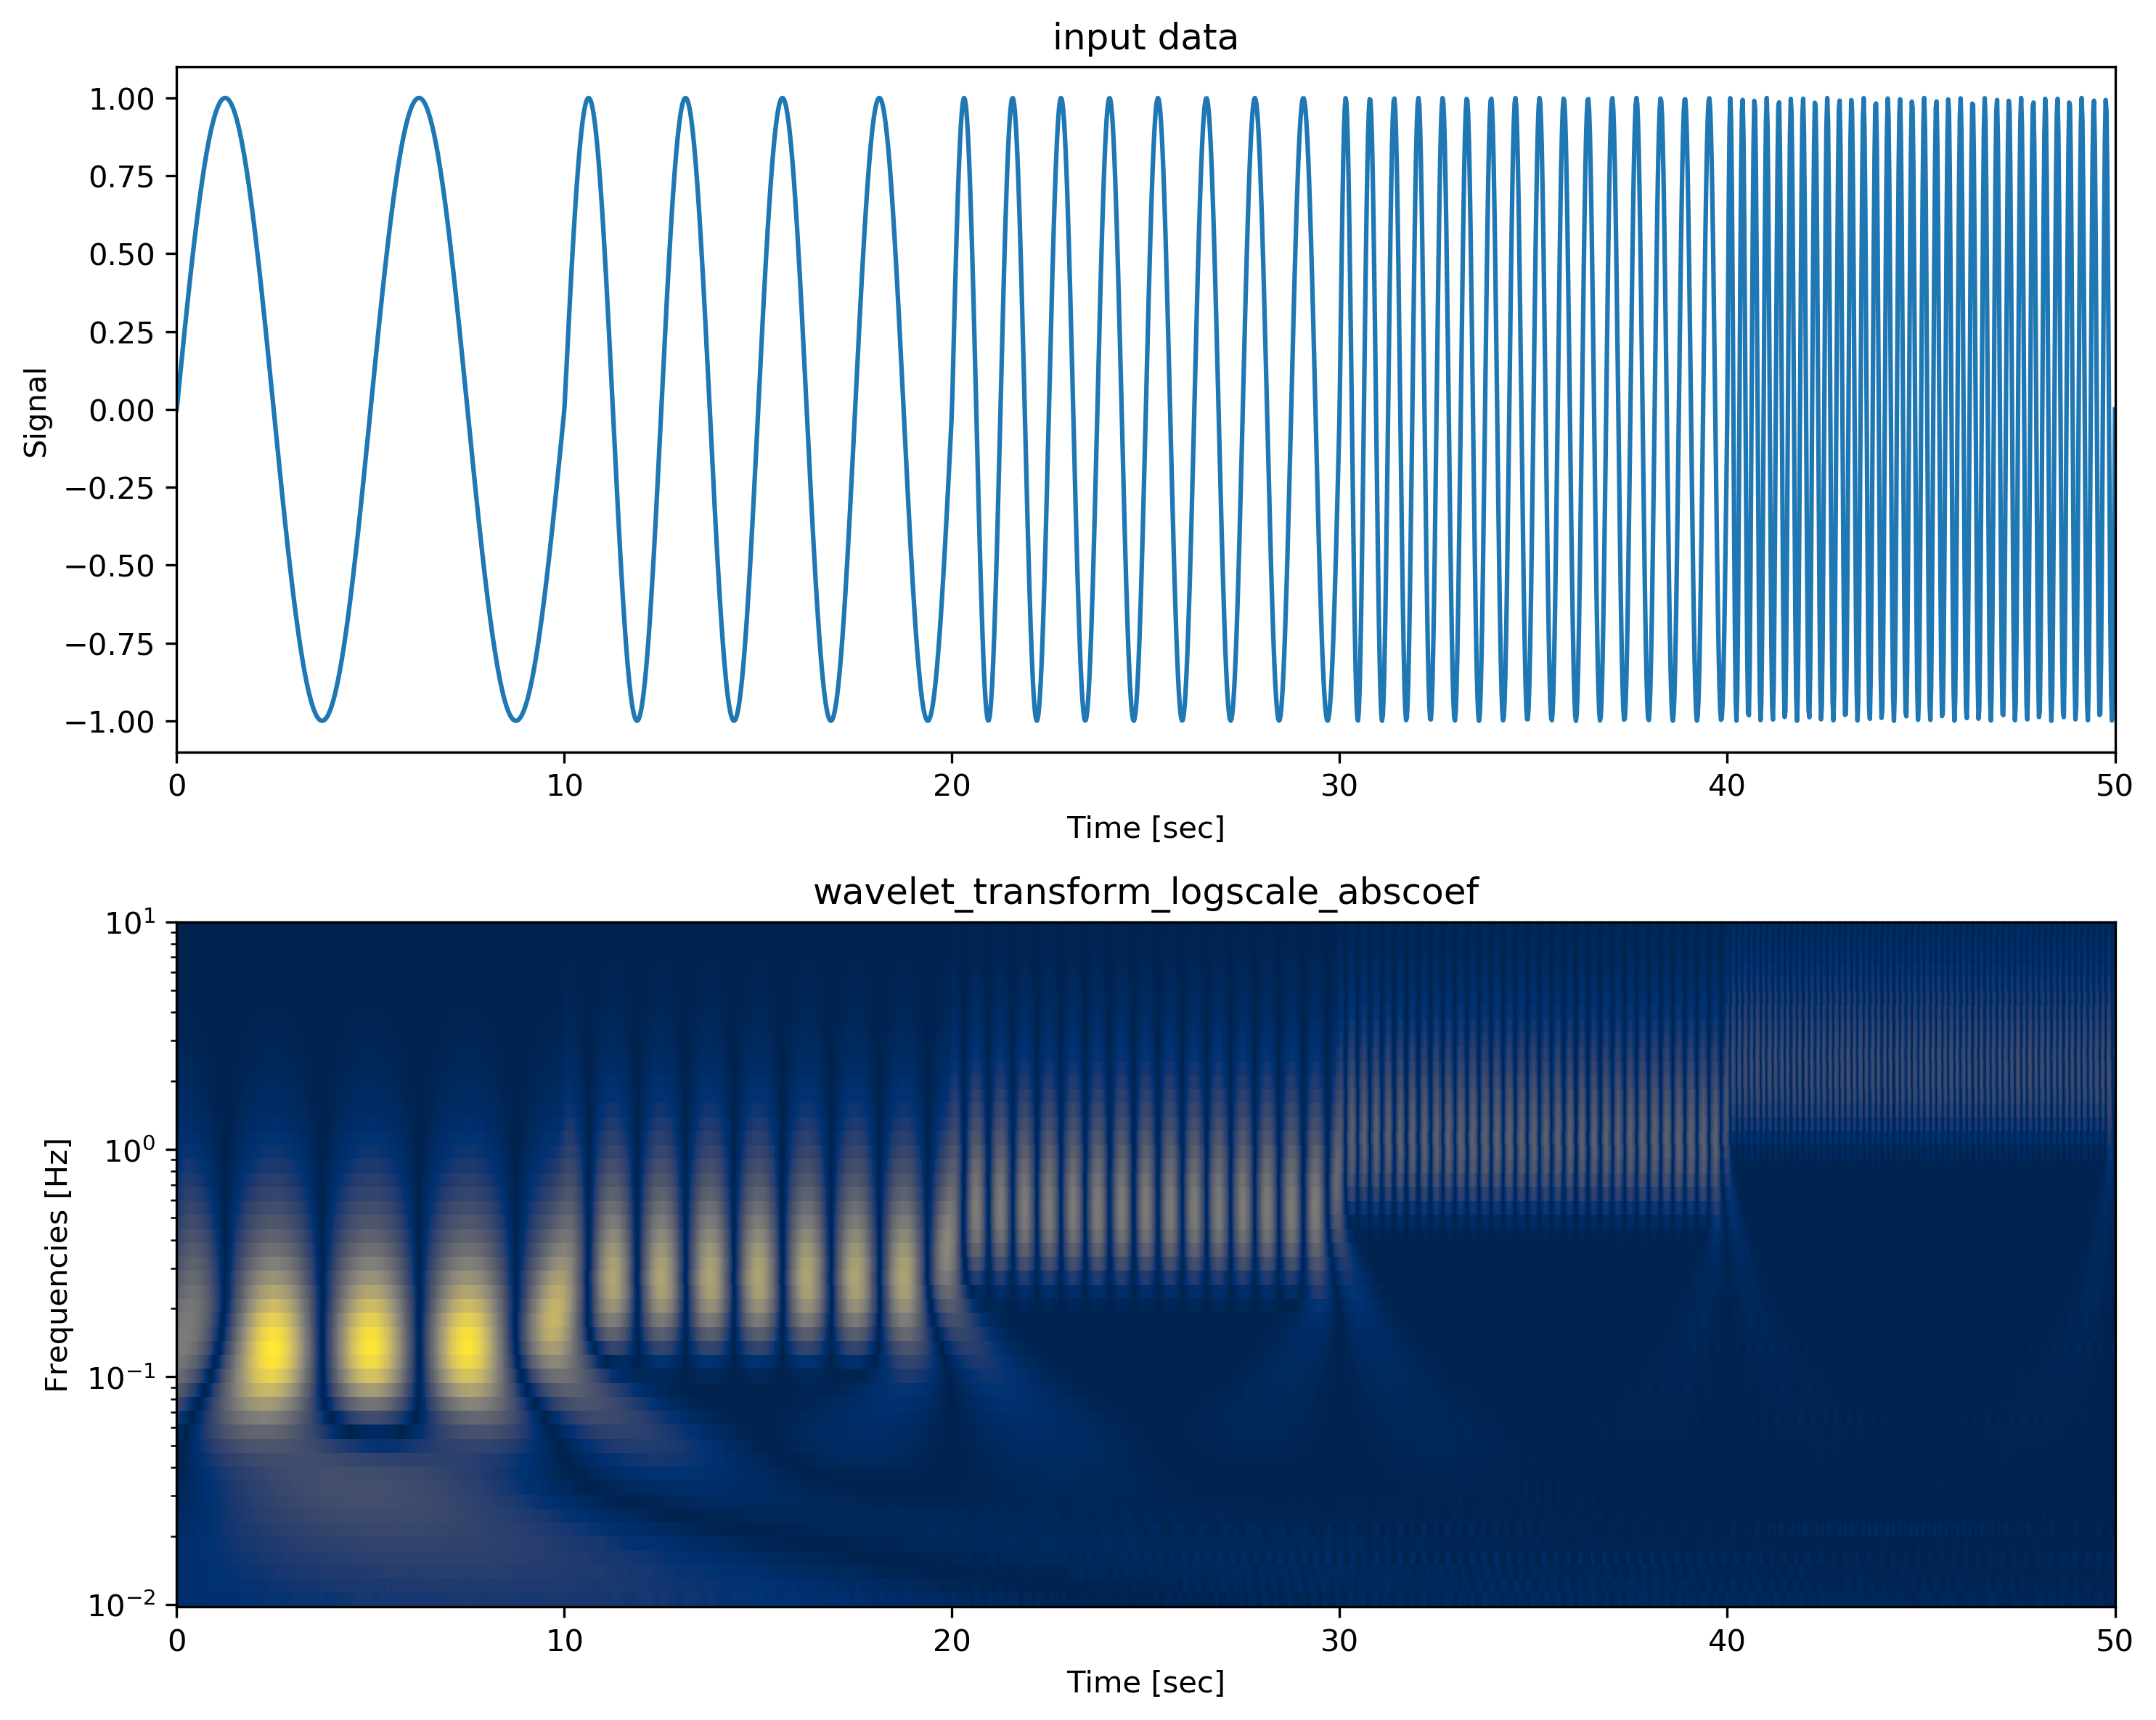

In [70]:
def wavelet_transform_logscale_abscoef(input_sig, wavelet=wavelet_name):
    scale_list = np.power(2.0, np.linspace(0.0, 10, 50))
    coef, freq = pywt.cwt(input_sig, scale_list, wavelet=wavelet, sampling_period=sampling_interval)
    coef_abs = np.abs(coef)
    plot_results(time_array, input_sig, freq, coef_abs, title=sys._getframe().f_code.co_name, xscale='log')


wavelet_transform_logscale_abscoef(input_data)

ここにきてようやく，最初に設定した，信号の周波数が0.2, 0.4, 0.8, 1.6, 3.2と倍々に増加していく様子がウェーブレットの結果からもわかるようになってきたと思います．気になるのは，信号の元々の振幅は一定なのに，ウェーブレット変換した結果は，高周波数になるに従って強度が低下しているように見えますね．これは，ざっくり説明すると，周波数が高くなるほど，ウェーブレット関数が圧縮されて，積分した絶対値が小さくなっていってしまうためです．これを規格化しようと思うと，出力されるウェーブレット係数を，入力時に渡したスケールで規格化していってあげるとうまくいくようです．

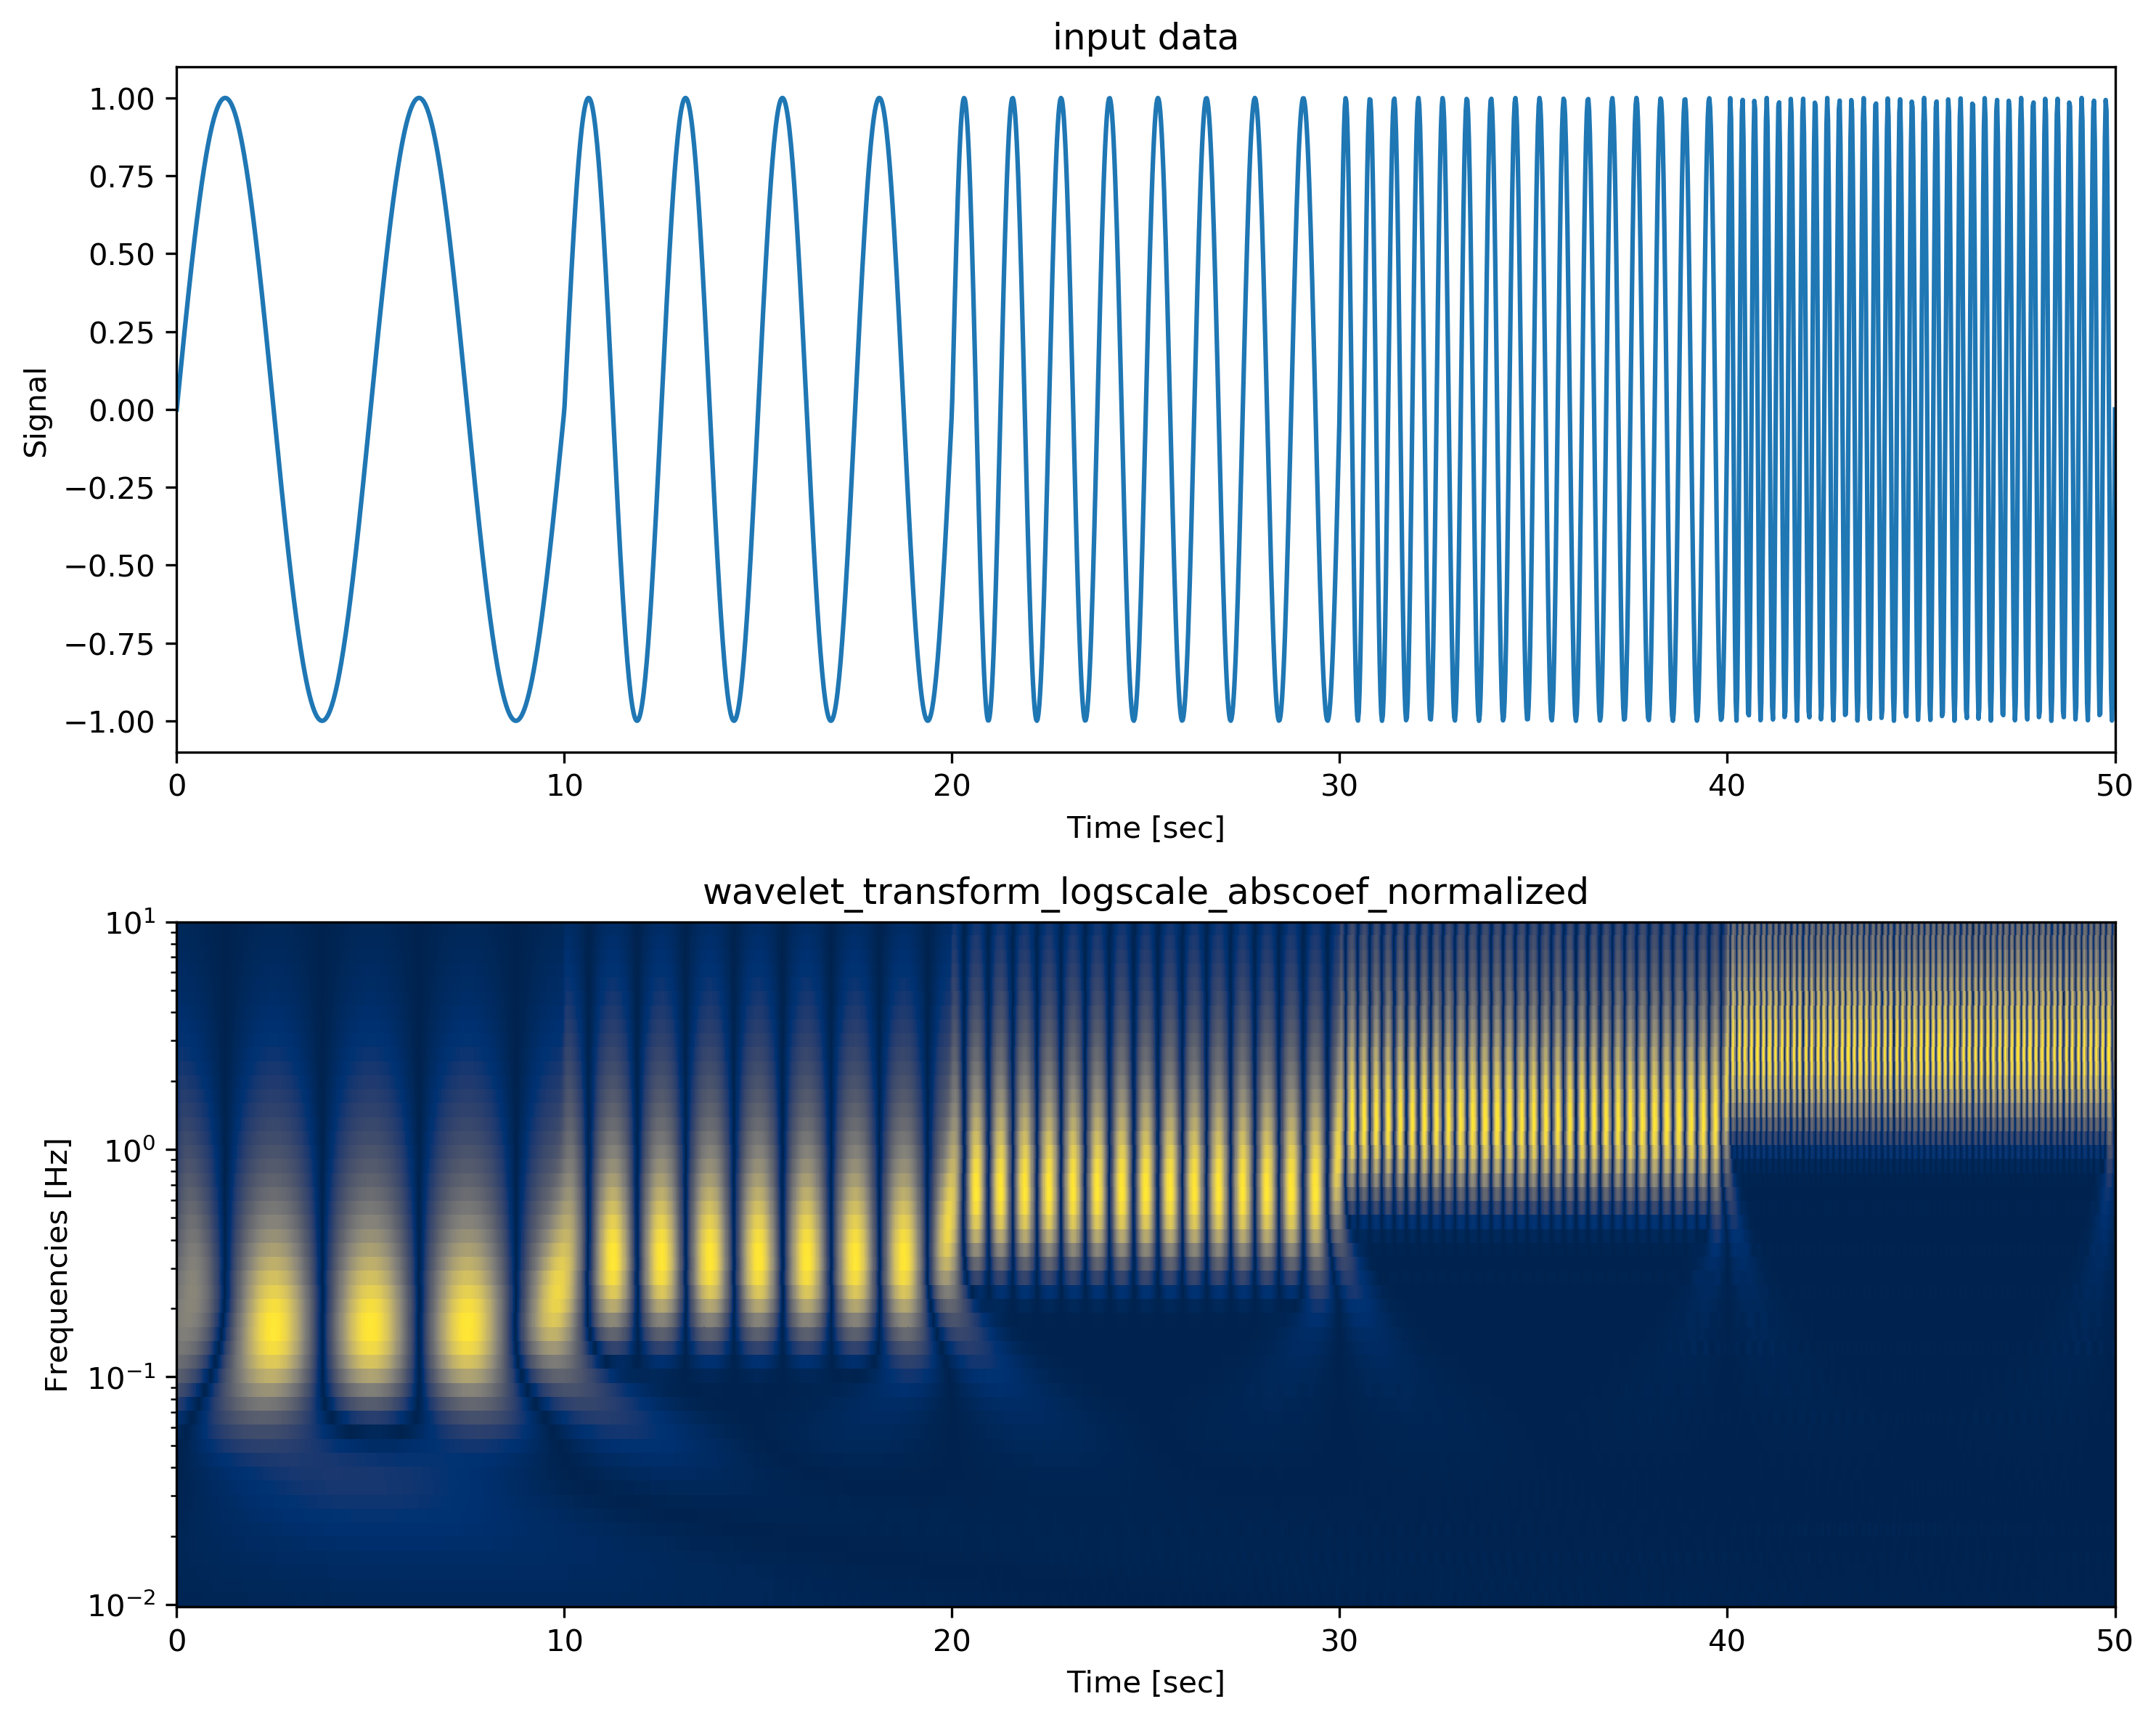

In [71]:
def wavelet_transform_logscale_abscoef_normalized(input_sig, wavelet=wavelet_name):
    scale_list = np.power(2.0, np.linspace(0.0, 10, 50))
    coef, freq = pywt.cwt(input_sig, scale_list, wavelet=wavelet, sampling_period=sampling_interval)
    coef_norm = coef
    for i, scale in enumerate(scale_list):
        coef_norm[i,:] = np.abs(coef[i,:]) / np.sqrt(scale)
    plot_results(time_array, input_sig, freq, coef_norm, title=sys._getframe().f_code.co_name, xscale='log')


wavelet_transform_logscale_abscoef_normalized(input_data)

これでとりあえずはどの周波数が支配的かを確かめられそうですね．試しに，周波数は変わらず，振幅だけが時間にそって増幅していくような信号で確かめてみましょうか．

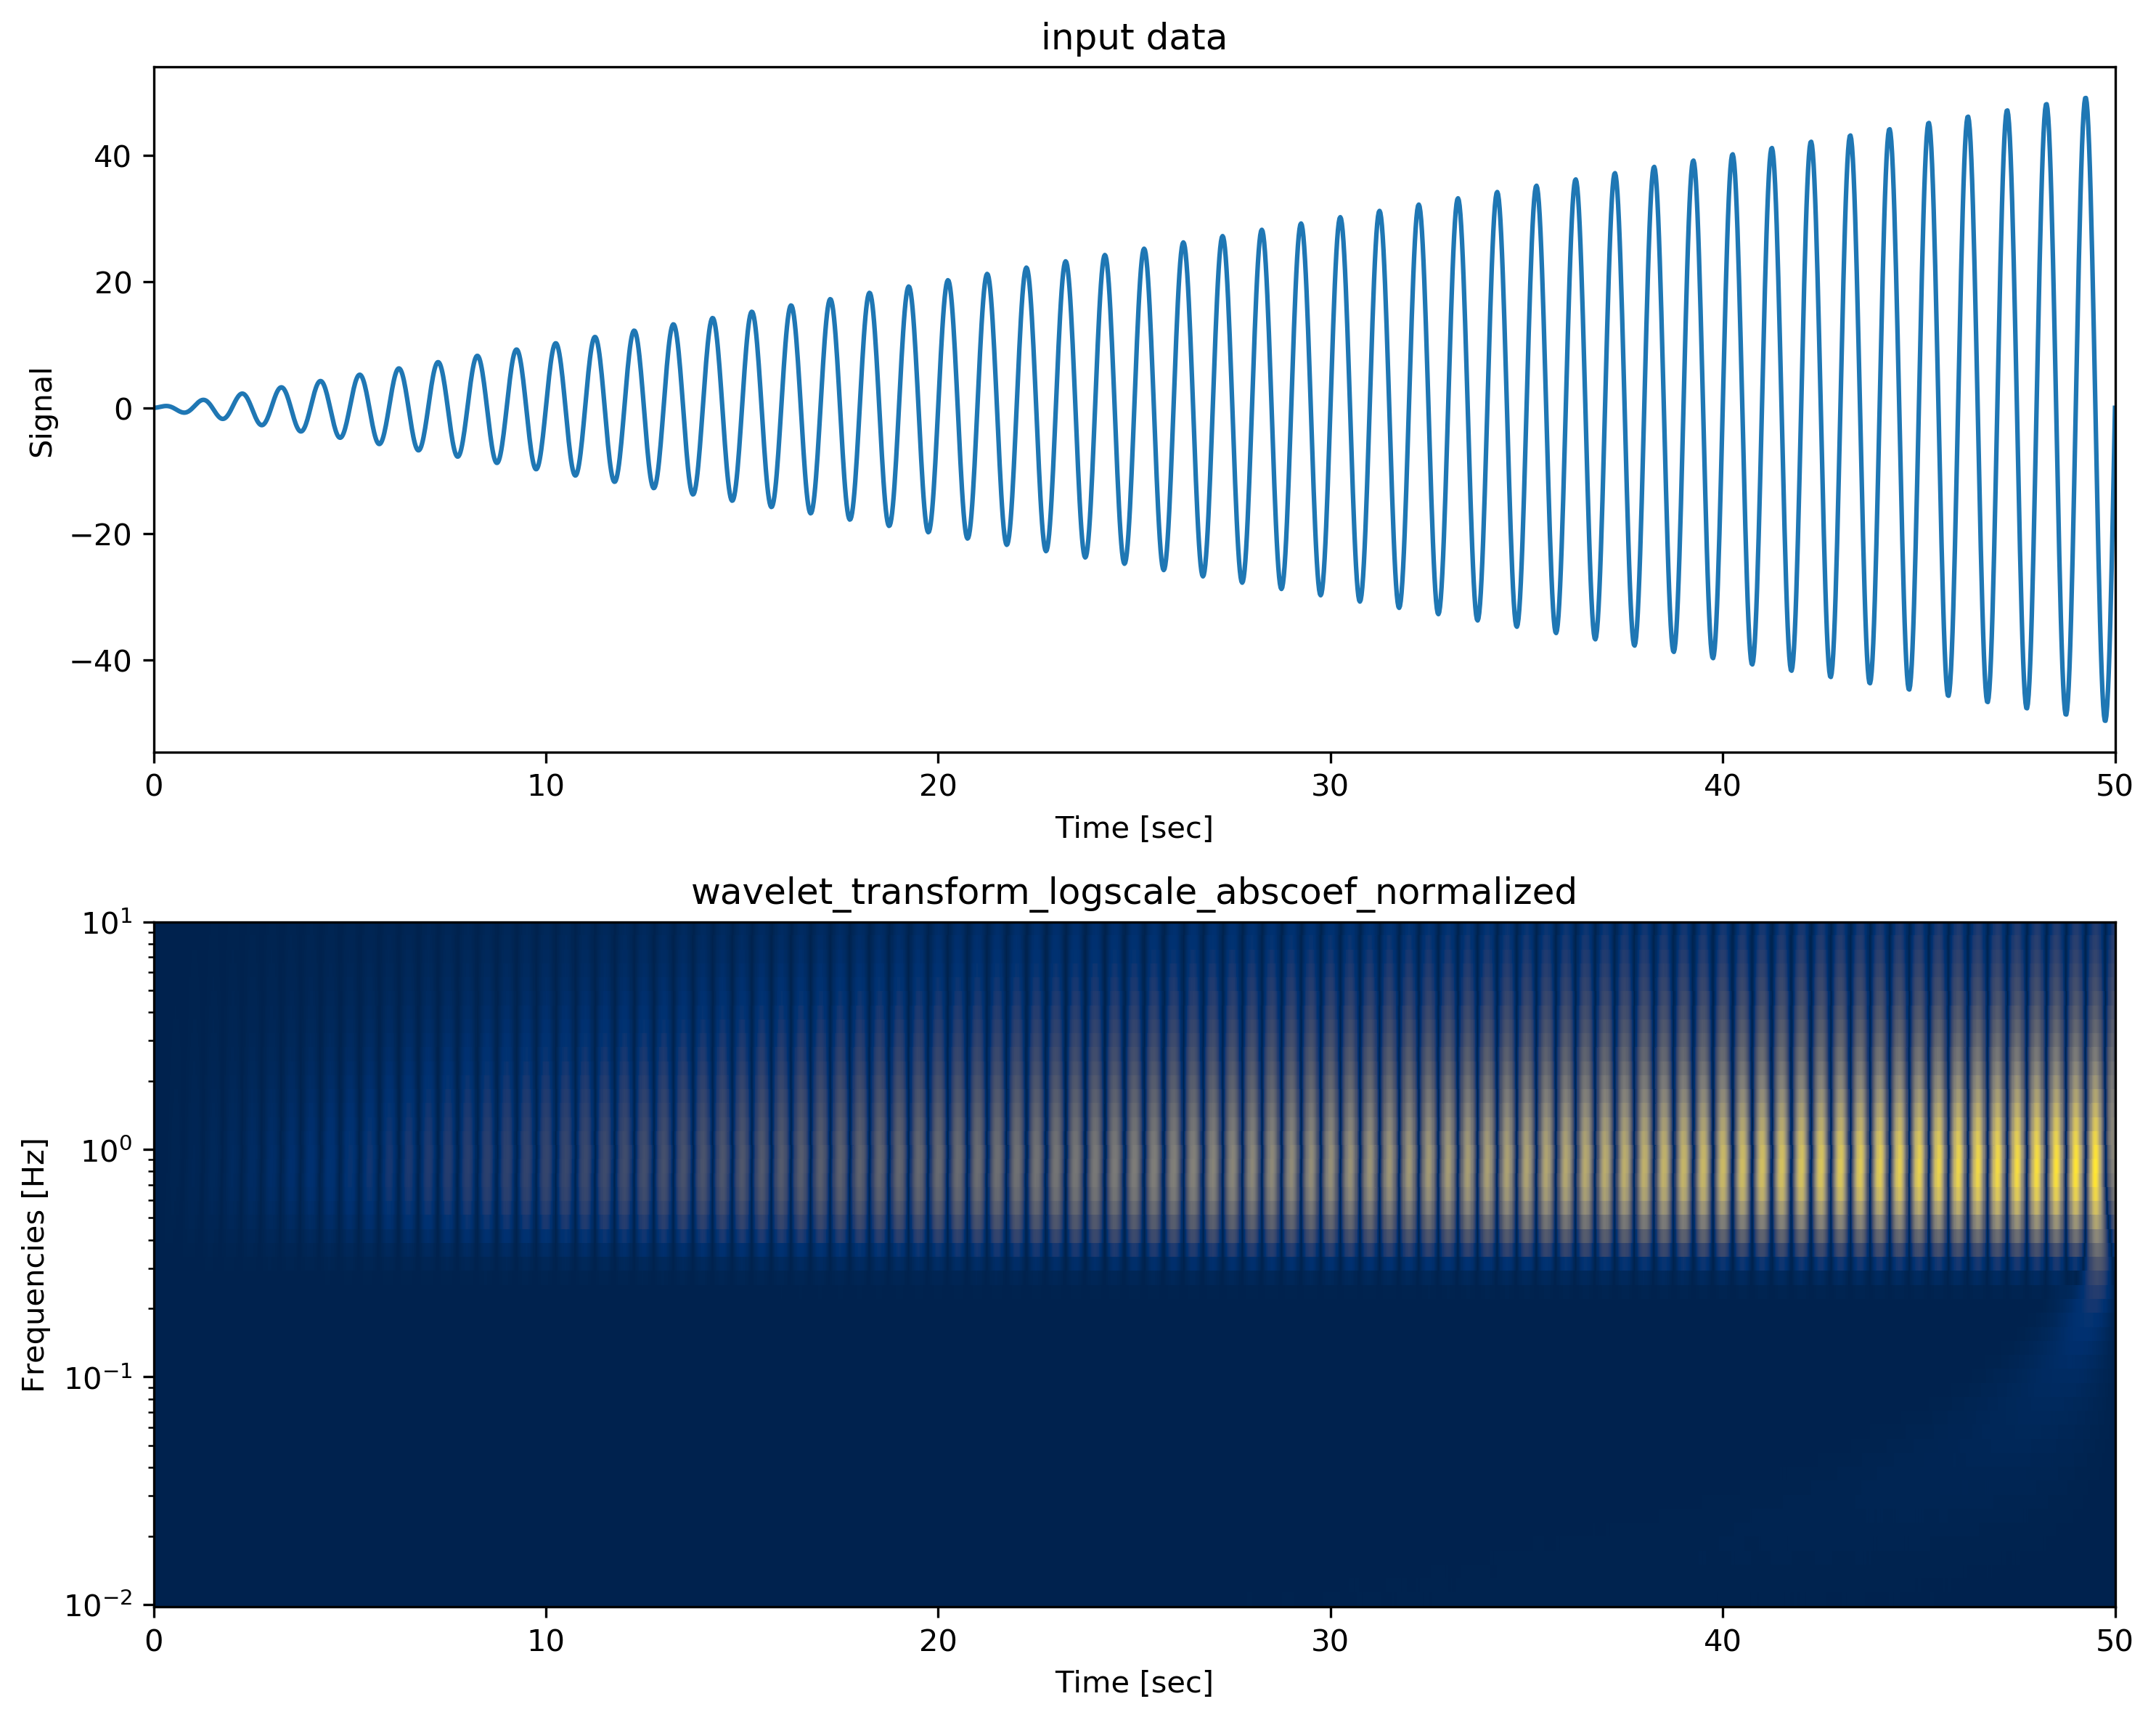

In [72]:
input_amp = np.sin(2.0 * np.pi * time_array) * time_array
wavelet_transform_logscale_abscoef_normalized(input_amp)

徐々に信号が増幅していく様子が捉えられていますね．周波数と振幅が同時に変化する場合も試しておきましょうか．

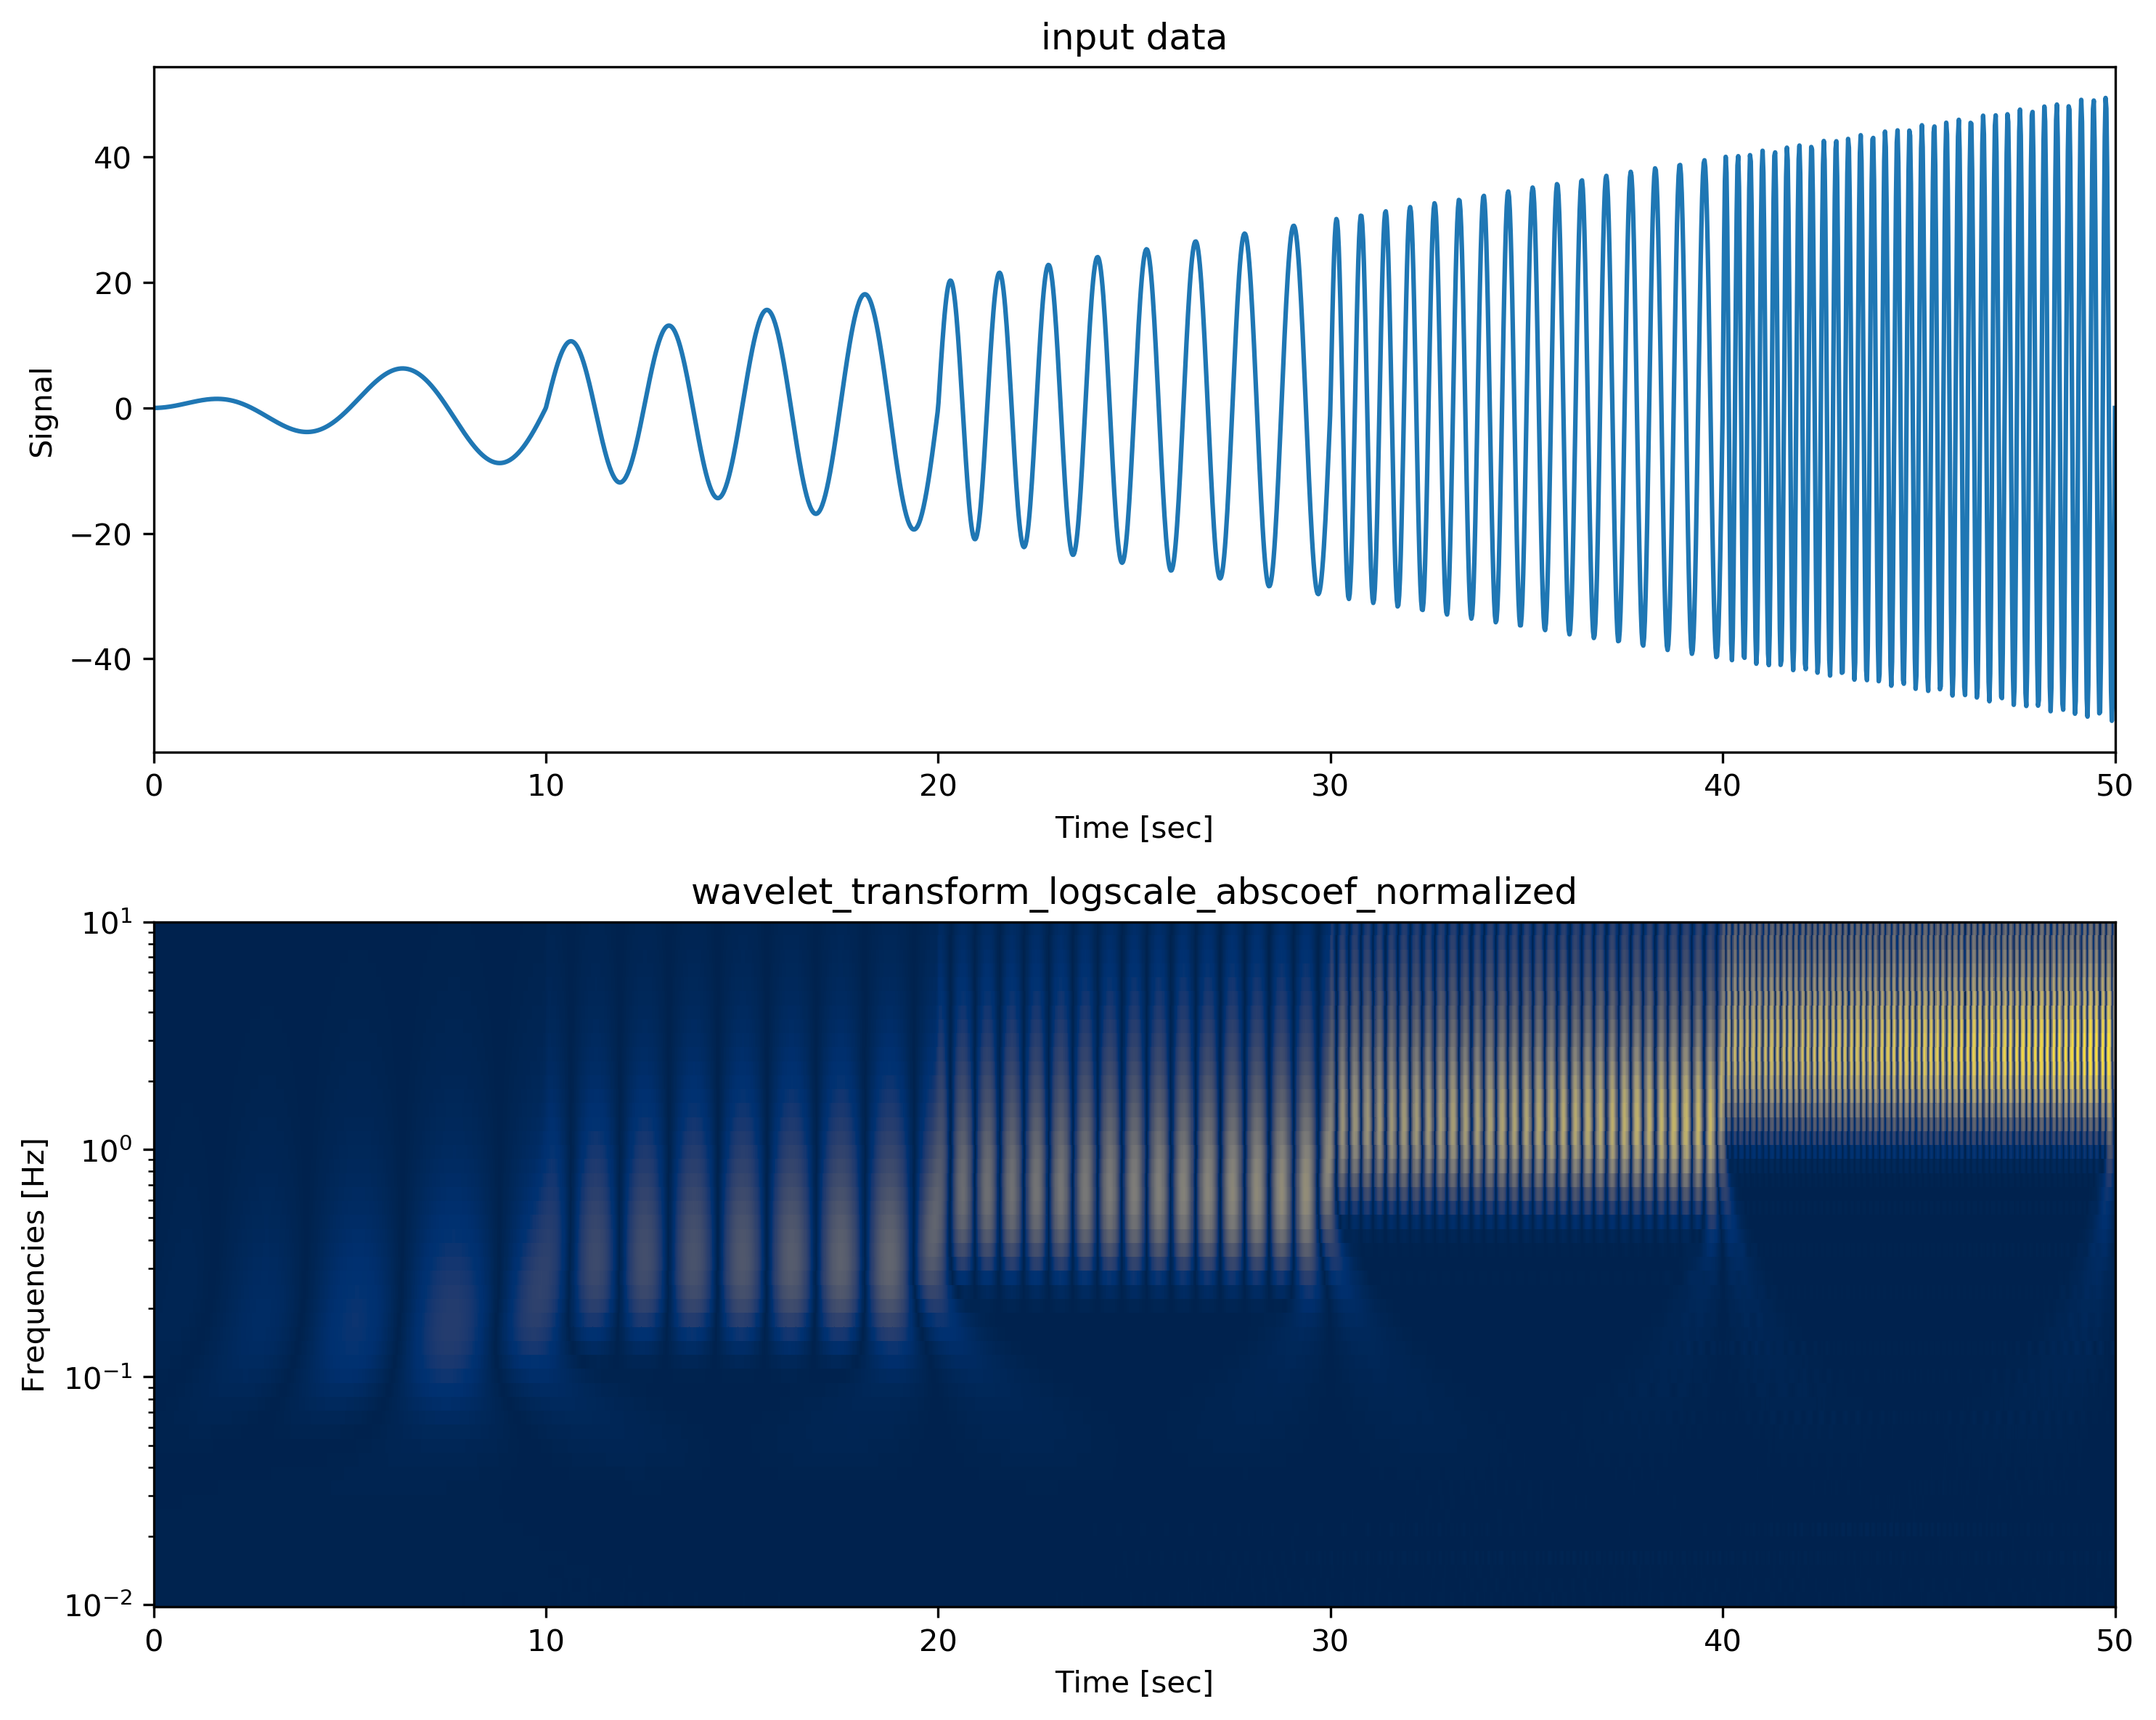

In [73]:
input_amp_freq = input_data * time_array
wavelet_transform_logscale_abscoef_normalized(input_amp_freq)

試しに波の重ね合わせパターンも．時間が経つにつれて高周波成分が増えていくと．．

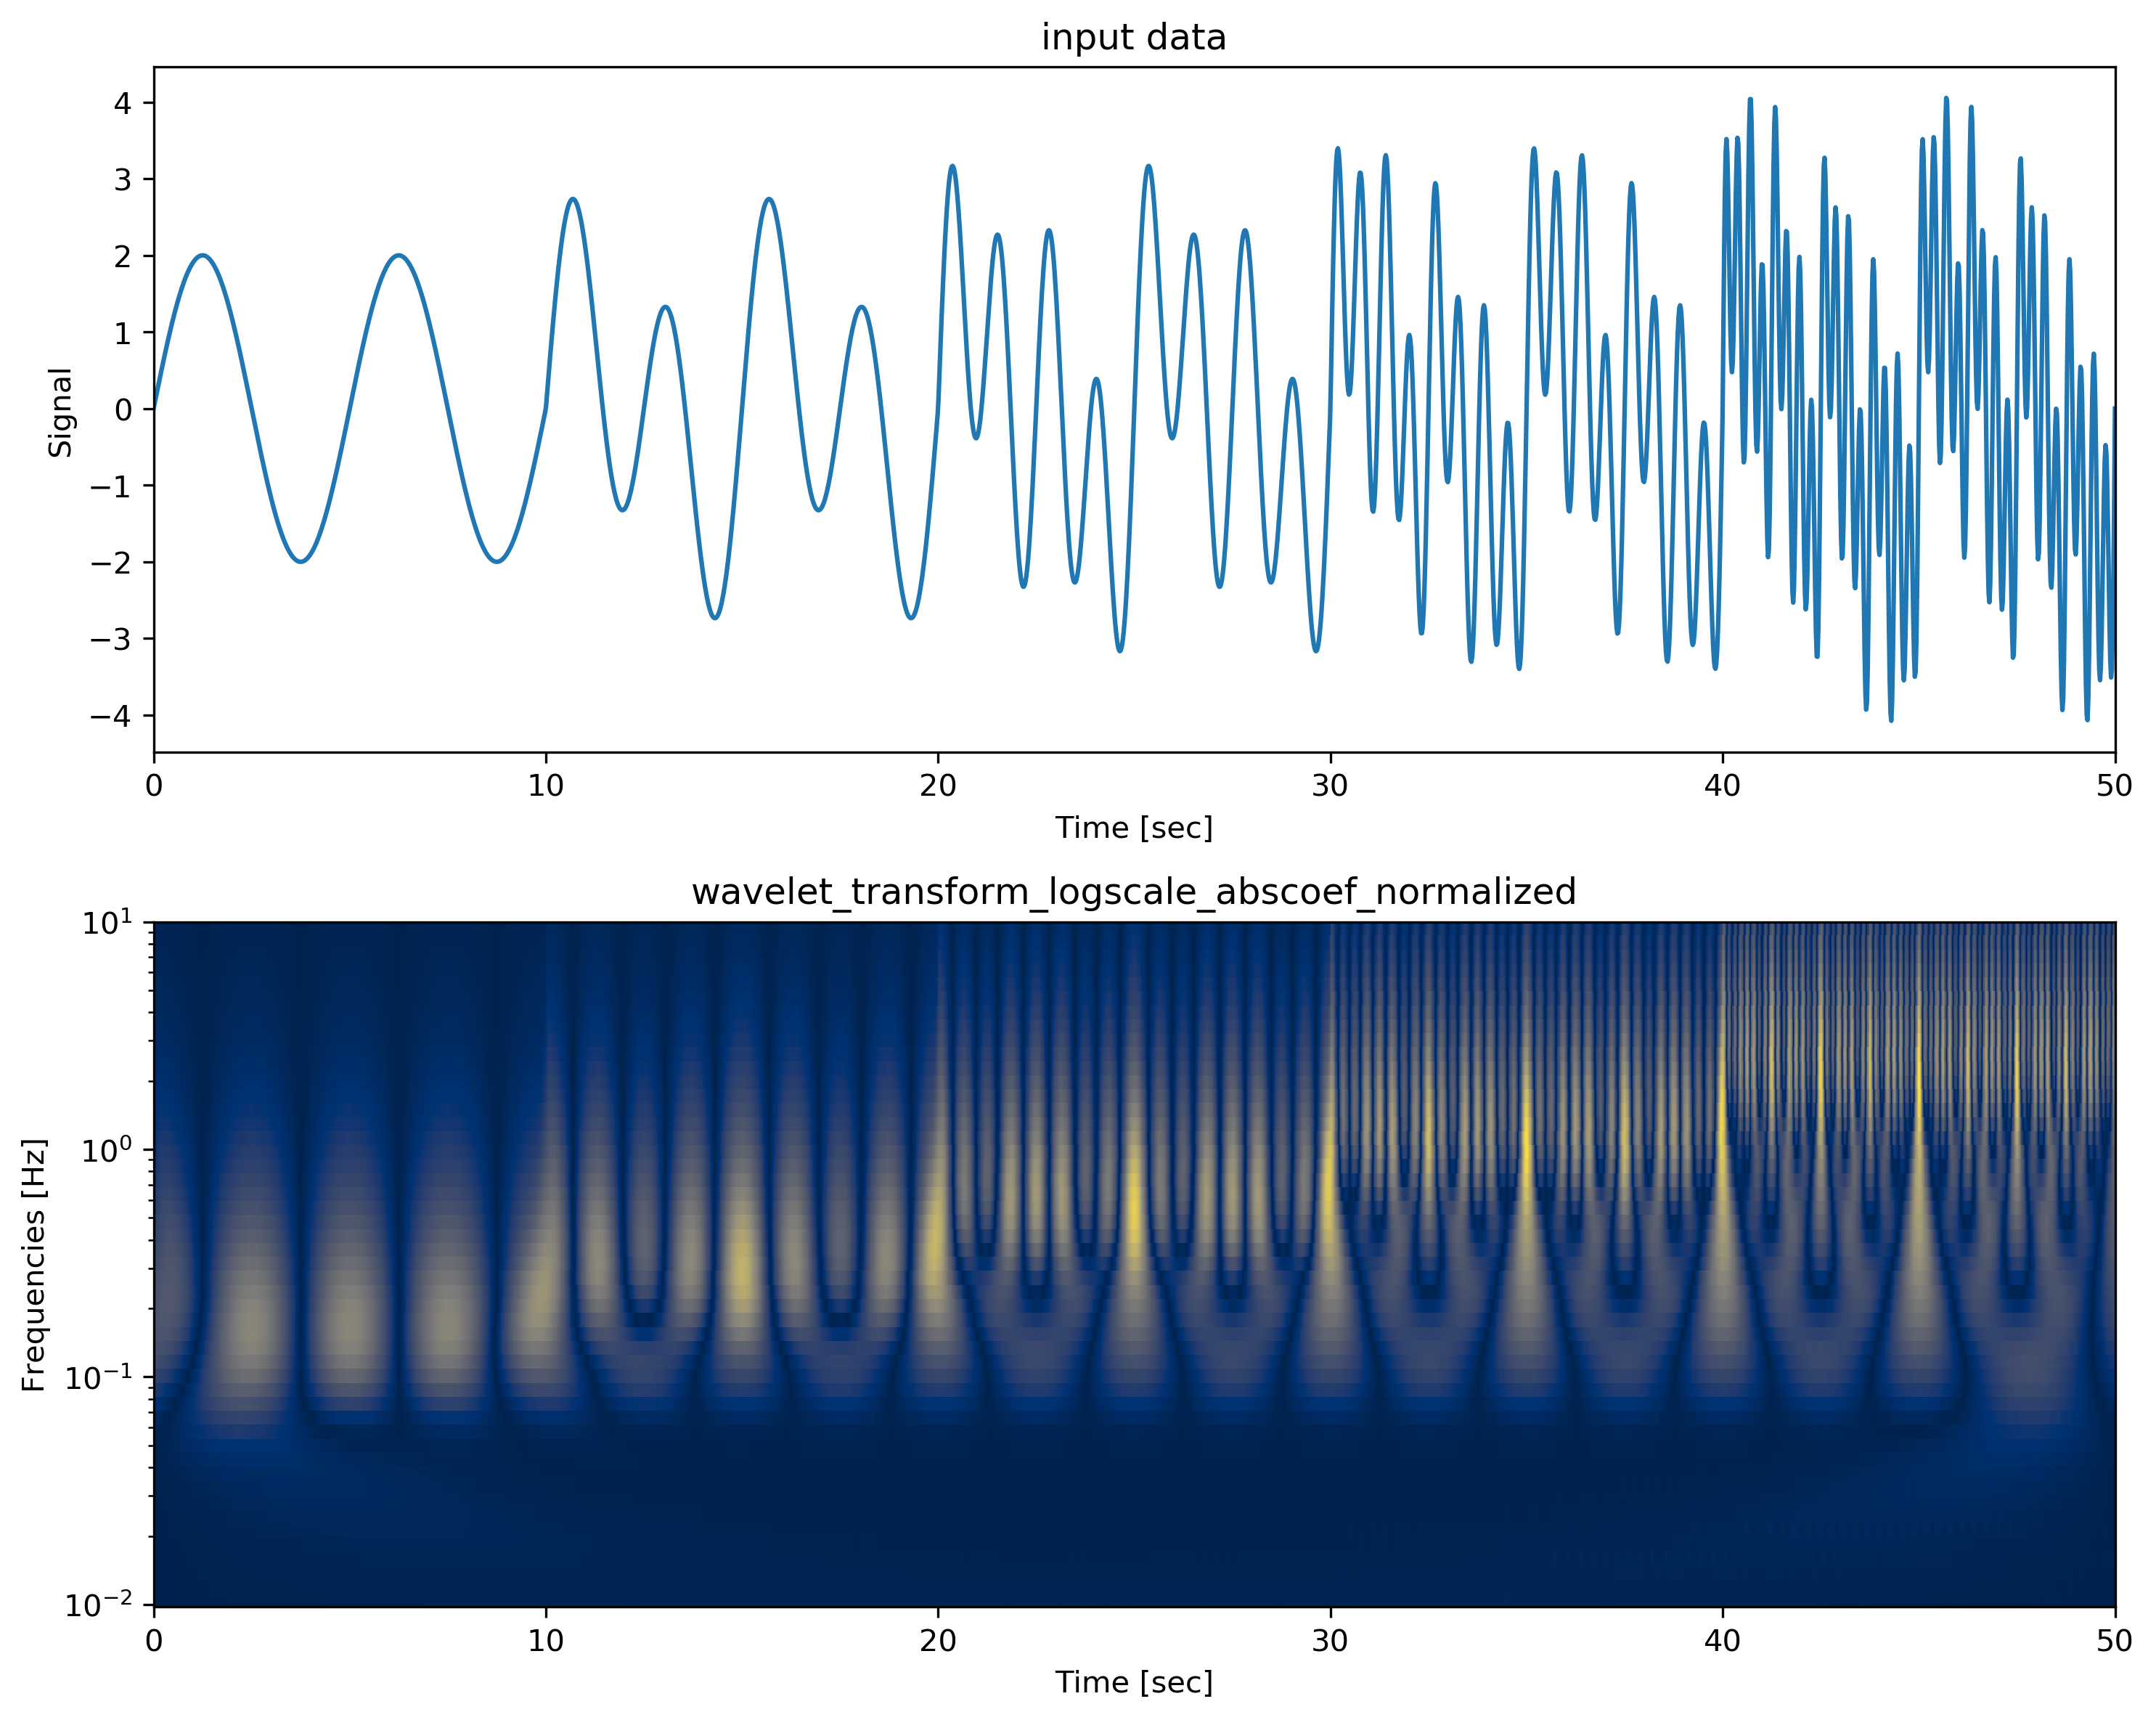

In [74]:
for i, freqs in enumerate(base_frequencies):
    input_data[int(i * data_num / num_input_freqs):] = input_data[int(i * data_num / num_input_freqs):] + \
        np.sin(2.0 * freqs * np.pi * time_array[int(i * data_num / num_input_freqs):])
wavelet_transform_logscale_abscoef_normalized(input_data)

正確な周波数を読み取るのは難しいですが，低周波に混じって高周波成分が増えていく様子は大まかにわかると思います．